In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'width': 1024, 'height': 768, 'scroll': True}

# Solving Knapsack problem using GPU genetic algortihm

![Knapsack Problem](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Knapsack.svg/486px-Knapsack.svg.png)

## Problem Definition

Maximize the value of items packed into the knapsack without exceeding its total capacity.

Given $n$ items to choose from, each item $i \in 0...n-1$ has a value $v_{i}$ and a
weight $w_{i}$. The knapsack has a limited capacity $W$. Let $x_{i}$ be a variable that is $1$ if you choose to take item $i$ and $0$ if you leave item $i$ behind.

$$\begin{array}{l l} 
\text{maximise:} \quad 
                    & \sum_{i \in 0...n-1} v_{i}x_{i} \\
\text{subject to:} \quad 
                    & \sum_{i \in 0...n-1} w_{i}x_{i} \leq W \\
                    & x_{i} \in \{0,1\} \quad (i \in 0...n-1)
\end{array}
$$

## Genetic algorithm
Five phases are considered in a genetic algorithm:
* Initial population
* Crossover
* Mutation
* Fitness function
* Selection

## Crossover
![](https://miro.medium.com/max/654/1*Wi6ou9jyMHdxrF2dgczz7g.png)



![](https://miro.medium.com/max/622/1*eQxFezBtdfdLxHsvSvBNGQ.png)

![](https://miro.medium.com/max/622/1*_Dl6Hwkay-UU24DJ_oVrLw.png)

## Fitness function

$$
x = (x_0, ..., x_{n-1}), x_i \in \{0,1\} \\
f(x) =    \begin{cases}
      \sum_{i \in 0...n-1} v_{i}x_{i} & \text{if } \sum_{i \in 0...n-1} w_{i}x_{i} \leq W \\
      -1 & \text{otherwise}
    \end{cases}      
$$

In each epoch we choose the best solutions according to fitness function.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cupy as cp
import time
import os
import pandas as pd

In [8]:
N = 1000
max_value = 1000
max_weight = 100
W = (N * max_weight)//5

values = np.random.randint(0, max_value, N)
weights = np.random.randint(0, max_weight, N)


mprob = .3
nb_epochs = 2000
population_size = 100

In [9]:
def xp_gen_alg(nb_of_epochs, p, x=np.array([1]), verbose=True):
    
    history = []
    mean_history = []
    #get cupy module or numpy module 
    xp = cp.get_array_module(x)
    #initialization
    population = xp.random.rand(population_size, N)
    population[population >= 1-p] = 1
    population[population < 1-p] = 0
    population = population.astype('int32')
    
    for j in range(nb_of_epochs):
        xp.random.shuffle(population)
        
        #crossover
        locus = xp.random.randint(N)
        population = xp.vstack([population, 
                        xp.hstack([population[:, :locus], xp.roll(population[:, locus:], shift=-1, axis=0)]),
                        xp.hstack([population[:, locus:], xp.roll(population[:, :locus], shift=-1, axis=0)]),
                       ])
        
        
        #mutation
        solutions_to_mutate = xp.random.choice(population_size, size=int(population_size*mprob), replace=False)
        for _ in range(10):
            gens_to_mutate = xp.random.choice(N, size=int(population_size*mprob))
            population[solutions_to_mutate, gens_to_mutate] = 1 - population[solutions_to_mutate, gens_to_mutate]


        #selection
        weights_of_pop = xp.sum(population*weights, axis=1)
        values_of_pop = xp.sum(population*values, axis=1)
        values_of_pop[weights_of_pop > W] = -1
        best_sols = xp.argsort(values_of_pop)[::-1][:population_size]
        population = population[best_sols]
        
        
        weights_of_pop = xp.sum(population*weights, axis=1)
        values_of_pop = xp.sum(population*values, axis=1)
        values_of_pop[weights_of_pop > W] = -1
        mean_history.append(values_of_pop.mean())
        
        
        if xp.sum(population[0]*weights) > W:
            best_val = -1
        else:
            best_val = xp.sum(population[0]*values)
        history.append(best_val)
        
        #zero_padding = np.log10(nb_epochs)
        if j%100 == 0 and verbose:
            print('{:04d}-th epoch is finished. Best solution = {:010d}'.format(j, best_val)) 

    return population[0], history, mean_history

In [13]:
solution, hist, mean_hist = xp_gen_alg(nb_epochs, .2, verbose=True)

0000-th epoch is finished. Best solution = 0000123458
0100-th epoch is finished. Best solution = 0000262149
0200-th epoch is finished. Best solution = 0000293529
0300-th epoch is finished. Best solution = 0000303999
0400-th epoch is finished. Best solution = 0000307608
0500-th epoch is finished. Best solution = 0000308982
0600-th epoch is finished. Best solution = 0000314167
0700-th epoch is finished. Best solution = 0000315851
0800-th epoch is finished. Best solution = 0000317047
0900-th epoch is finished. Best solution = 0000319715
1000-th epoch is finished. Best solution = 0000321370
1100-th epoch is finished. Best solution = 0000322608
1200-th epoch is finished. Best solution = 0000323028
1300-th epoch is finished. Best solution = 0000324624
1400-th epoch is finished. Best solution = 0000326184
1500-th epoch is finished. Best solution = 0000326184
1600-th epoch is finished. Best solution = 0000326972
1700-th epoch is finished. Best solution = 0000327019
1800-th epoch is finished. B

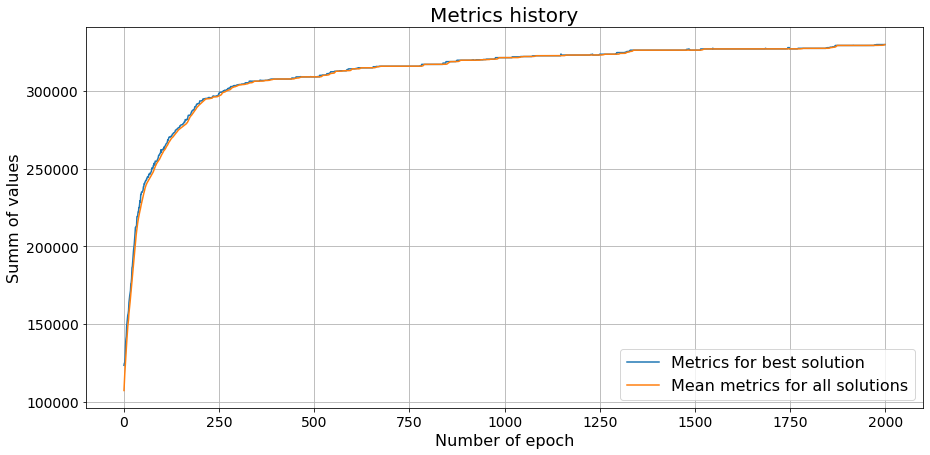

In [16]:
plt.figure(figsize=(15,7))
plt.title('Metrics history', fontsize=20)
plt.xlabel('Number of epoch', fontsize=16)
plt.ylabel('Summ of values', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(hist, label='Metrics for best solution')
plt.plot(mean_hist, label='Mean metrics for all solutions')
plt.legend(fontsize=16)

In [82]:
N_range = [10**i for i in range(1, 5)]
pop_size_range = [10, 100, 500, 1000]

np_times = {N: [] for N in N_range}

cp_times = {N: [] for N in N_range}

for N in N_range:
    max_value = 1000
    max_weight = 100
    W = (N * max_weight)//5
    mprob = .3
    nb_epochs = 10
    values = np.random.randint(0, max_value, N)
    weights = np.random.randint(0, max_weight, N)
    for pop_size in pop_size_range:
        population_size = pop_size

        values = np.random.randint(0, max_value, N)
        weights = np.random.randint(0, max_weight, N)

        start = time.time()
        solution, history = xp_gen_alg(nb_epochs, p=0.1, x=np.array([1]))
        duration = time.time() - start
        np_times[N].append(duration)

        values = cp.random.randint(0, max_value, N)
        weights = cp.random.randint(0, max_weight, N)
        
        start = time.time()
        solution, history = xp_gen_alg(nb_epochs, p=0.1, x=cp.array([1]))
        duration = time.time() - start
        cp_times[N].append(duration)
    print('{} is finished'.format(N))

10 is finished
100 is finished
1000 is finished
10000 is finished


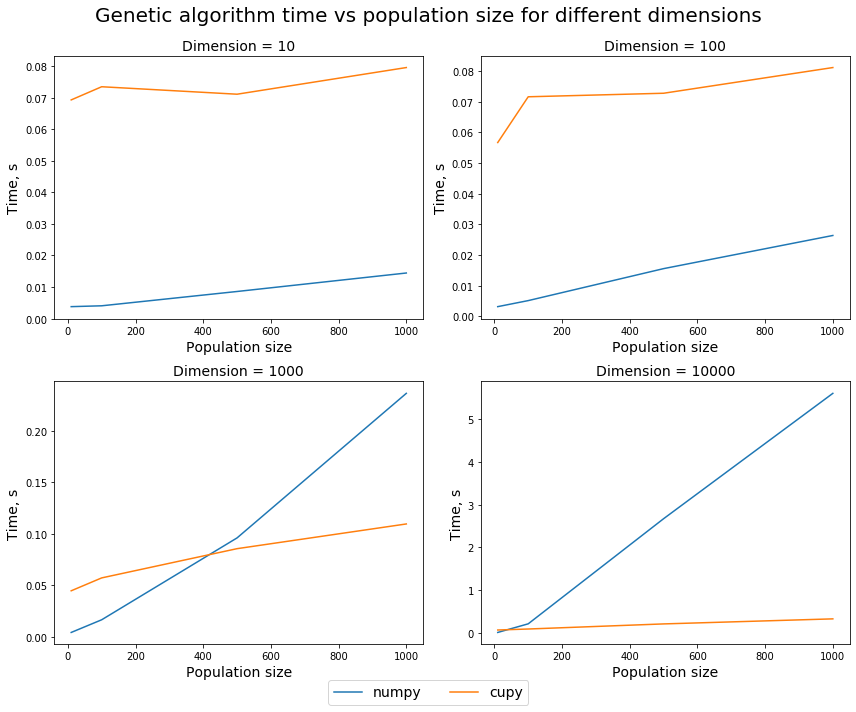

In [124]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
plt.suptitle('Genetic algorithm time vs population size for different dimensions', fontsize=20)
for i in range(4):
    ax[i//2, i%2].plot(pop_size_range, np_times[N_range[i]], label='numpy')
    ax[i//2, i%2].plot(pop_size_range, cp_times[N_range[i]], label='cupy')
    ax[i//2, i%2].set_title('Dimension = {}'.format(N_range[i]), fontsize=14)
    ax[i//2, i%2].set_ylabel('Time, s', fontsize=14)
    ax[i//2, i%2].set_xlabel('Population size', fontsize=14)
    #ax[i//2, i%2].legend()
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [349]:
def xp_gen_alg(nb_of_epochs, p, x=np.array([1]), verbose=True):
    
    history = []
    
    #get cupy module or numpy module 
    xp = cp.get_array_module(x)
    #initialization
    population = xp.zeros((population_size, N), dtype='int32')
    for j in range(population_size):
        gens_to_choose = np.random.choice(N, size=int(N*p), p=cp.asnumpy(values/weights/cp.sum(values/weights)),replace=False)
        population[j][gens_to_choose] = 1
    
    for j in range(nb_of_epochs):
        xp.random.shuffle(population)
            
        #crossover
        locus = xp.random.randint(N)
        population = xp.vstack([population, 
                        xp.hstack([population[:, :locus], xp.roll(population[:, locus:], shift=-1, axis=0)]),
                        xp.hstack([population[:, locus:], xp.roll(population[:, :locus], shift=-1, axis=0)]),
                       ])
        
        
        #mutation
        solutions_to_mutate = xp.random.choice(population_size, size=int(population_size*mprob), replace=False)
        for _ in range(10):
            gens_to_mutate = xp.random.choice(N, size=int(population_size*mprob))
            population[solutions_to_mutate, gens_to_mutate] = 1 - population[solutions_to_mutate, gens_to_mutate]


        #selection
        weights_of_pop = xp.sum(population*weights, axis=1)
        values_of_pop = xp.sum(population*values, axis=1)
        values_of_pop[weights_of_pop > W] = -1
        values_of_pop[weights_of_pop > W] = values_of_pop[weights_of_pop > W] - (W-weights_of_pop[weights_of_pop > W])**2
        best_sols = xp.argsort(values_of_pop)[::-1][:population_size]
        population = population[best_sols]
        
        #verbosity
        if xp.sum(population[0]*weights) > W:
            best_val = -1
        else:
            best_val = xp.sum(population[0]*values)
        history.append(best_val)
        
        if j%100 == 0 and verbose:
            print('{:04d}-th epoch is finished. Best solution = {:010d}'.format(j, best_val)) 

    return population[0], history

In [6]:
#training dataset for knapsack
#http://artemisa.unicauca.edu.co/~johnyortega/instances_01_KP/

dataset_folder = 'instances_01_KP/large_scale/'
optimum_folder = 'instances_01_KP/large_scale-optimum/'

def get_data_from_text(dataset_name):
    f = open(os.path.join(dataset_folder, dataset_name))
    s = f.readline()
    N, W = map(int, s.split())
    values = []
    weights = []
    ss = ''
    for s in f.readlines():
        if len(values) < N:
            v, w = map(int, s.split())
            values.append(v)
            weights.append(w)
            
    f = open(os.path.join(optimum_folder, dataset_name))
    opt_value = int(f.readline().split()[0])
    
    return N, W, np.array(values), np.array(weights), opt_value

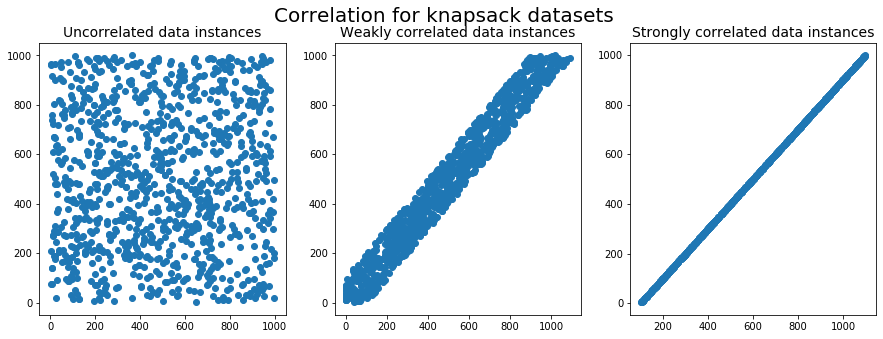

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
names = [
    'Uncorrelated data instances',
    'Weakly correlated data instances',
    'Strongly correlated data instances'
]
plt.suptitle('Correlation for knapsack datasets', fontsize=20)
for i in [1,2,3]:
    N, W, values, weights, opt_value = get_data_from_text('knapPI_{}_1000_1000_1'.format(i))
    #values, weights = cp.asnumpy(values), cp.asnumpy(weights)
    ax[i-1].scatter(values, weights)
    ax[i-1].set_title(names[i-1], fontsize=14)


In [350]:
dataset_folder = 'instances_01_KP/large_scale/'
optimum_folder = 'instances_01_KP/large_scale-optimum/'

def get_data_from_text(dataset_name):
    f = open(os.path.join(dataset_folder, dataset_name))
    s = f.readline()
    N, W = map(int, s.split())
    values = []
    weights = []
    ss = ''
    for s in f.readlines():
        if len(values) < N:
            v, w = map(int, s.split())
            values.append(v)
            weights.append(w)
            
    f = open(os.path.join(optimum_folder, dataset_name))
    opt_value = int(f.readline().split()[0])
    
    return N, W, cp.array(values), cp.array(weights), opt_value

In [373]:
N_range = [100, 200, 500, 1000, 2000, 5000, 10000]
opt_values = []
my_values = []

for i in N_range:
    N, W, values, weights, opt_value = get_data_from_text('knapPI_3_{}_1000_1'.format(i))
    mprob = .3
    nb_epochs = 100
    population_size = max(100, N//50)
    opt_values.append(opt_value)
    print('{} is started'.format(i))
    solution, hist = xp_gen_alg(nb_epochs, .01, x=cp.array([1]), verbose=False)
    assert cp.sum(solution*weights) <= W
    my_value = cp.sum(solution*values).item()
    my_values.append(my_value)
    print('Optimum value = {}, obtained value = {}'.format(opt_value, my_value))

100 is started
Optimum value = 2397, obtained value = 1395
200 is started
Optimum value = 2697, obtained value = 1487
500 is started
Optimum value = 7117, obtained value = 3710
1000 is started
Optimum value = 14390, obtained value = 6844
2000 is started
Optimum value = 28919, obtained value = 13618
5000 is started
Optimum value = 72505, obtained value = 32295
10000 is started
Optimum value = 146919, obtained value = 65795


In [364]:
df = pd.DataFrame(data=[opt_values, my_values]).T

df[2] = opt_values
df[3] = my_values

df[4] = opt_values
df[5] = my_values

In [376]:
df.index = N_range
df.columns = ['opt UCI', 'my UCI', 'opt WCI', 'my WCI', 'opt SCI', 'my SCI']
df = df[['my UCI', 'opt UCI', 'my WCI', 'opt WCI', 'my SCI', 'opt SCI']]

In [393]:
df.columns = [
    'Uncorrelated data instances.\nObtained solution',
    'Uncorrelated data instances.\nTrue solution',
    'Weakly correlated data instances.\nObtained solution',
    'Weakly correlated data instances.\nTrue solution',   
    'Strongly correlated data instances.\nObtained solution',
    'Strongly correlated data instances.\nTrue solution'
]

In [394]:
df

,Uncorrelated data instances. Obtained solution,Uncorrelated data instances. True solution,Weakly correlated data instances. Obtained solution,Weakly correlated data instances. True solution,Strongly correlated data instances. Obtained solution,Strongly correlated data instances. True solution
100,7689,9147,1211,1514,1395,2397
200,9891,11238,1254,1634,1487,2697
500,22640,28857,2972,4566,3710,7117
1000,39381,54503,5811,9052,6844,14390
2000,66401,110625,11491,18051,13618,28919
5000,128873,276457,27046,44356,32295,72505
10000,258870,563647,55567,90204,65795,146919
